# Install Requirement

In [1]:
!pip install roboflow
!pip install ultralytics
!pip install huggingface-hub
!pip install albumentations

In [2]:
!nvidia-smi

Sun Jan 12 19:31:56 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.02              Driver Version: 560.94         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060        On  |   00000000:01:00.0  On |                  N/A |
|  0%   52C    P8             13W /  170W |    1074MiB /  12288MiB |     14%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# Import required packages

In [4]:
import albumentations as A
import cv2
import os
import glob
import matplotlib.pyplot as plt
from pathlib import Path
from IPython import display
import ultralytics

# YOLOv11 Ultralytics

In [5]:
display.clear_output()
ultralytics.checks()

Ultralytics 8.3.53 🚀 Python-3.10.12 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 3060, 12288MiB)
Setup complete ✅ (20 CPUs, 15.5 GB RAM, 87.3/1006.9 GB disk)


# Prepare data

In [6]:
# drive.mount('/content/drive')

## Data augmentation

In [7]:
transform = A.Compose(
    [
        A.Rotate(limit=30, p=0.8),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.3),
        A.RandomBrightnessContrast(p=0.7),
        A.Blur(blur_limit=3, p=0.3),
        A.CLAHE(p=0.3),
        A.Resize(640, 640, always_apply=True)
    ],
    bbox_params=A.BboxParams(format="yolo", label_fields=["category_ids"])
)

In [8]:
def augment_images(images_dir, labels_dir, save_dir, aug_count=1):
    images_path = sorted(glob.glob(os.path.join(images_dir, "*.jpg")))
    labels_path = sorted(glob.glob(os.path.join(labels_dir, "*.txt")))

    Path(save_dir / "images").mkdir(parents=True, exist_ok=True)
    Path(save_dir / "labels").mkdir(parents=True, exist_ok=True)

    for img_path, lbl_path in zip(images_path, labels_path):
        image = cv2.imread(img_path)
        height, width, _ = image.shape

        with open(lbl_path, "r") as f:
            boxes = []
            category_ids = []
            for line in f:
                class_id, x, y, w, h = map(float, line.strip().split())
                boxes.append([x, y, w, h])
                category_ids.append(int(class_id))

        for i in range(aug_count):
            augmented = transform(image=image, bboxes=boxes, category_ids=category_ids)
            aug_image = augmented["image"]
            aug_boxes = augmented["bboxes"]
            aug_category_ids = augmented["category_ids"]

            aug_img_filename = f"{Path(img_path).stem}_aug_{i}.jpg"
            aug_img_path = os.path.join(save_dir, "images", aug_img_filename)
            cv2.imwrite(aug_img_path, aug_image)

            aug_lbl_filename = f"{Path(lbl_path).stem}_aug_{i}.txt"
            aug_lbl_path = os.path.join(save_dir, "labels", aug_lbl_filename)
            with open(aug_lbl_path, "w") as f:
                for cat_id, bbox in zip(aug_category_ids, aug_boxes):
                    f.write(f"{cat_id} {bbox[0]} {bbox[1]} {bbox[2]} {bbox[3]}\n")

In [9]:
train_images_dir = "/home/rowan/safety-construction/dataset/train/images"
train_labels_dir = "/home/rowan/safety-construction/dataset/train/labels"
augmented_save_dir = Path("/home/rowan/safety-construction/dataset/augmented/train")

In [11]:
augment_images(train_images_dir, train_labels_dir, augmented_save_dir, aug_count=2)

## Count the augmented data

In [12]:
def count_data(images_dir, labels_dir, augmented_dir):
    num_original_images = len(glob.glob(os.path.join(images_dir, "*.jpg")))
    num_original_labels = len(glob.glob(os.path.join(labels_dir, "*.txt")))

    aug_images_dir = os.path.join(augmented_dir, "images")
    aug_labels_dir = os.path.join(augmented_dir, "labels")
    num_augmented_images = len(glob.glob(os.path.join(aug_images_dir, "*.jpg")))
    num_augmented_labels = len(glob.glob(os.path.join(aug_labels_dir, "*.txt")))

    total_images = num_original_images + num_augmented_images
    total_labels = num_original_labels + num_augmented_labels

    print(f"Number of original images: {num_original_images}")
    print(f"Number of original labels: {num_original_labels}")
    print(f"Number of augmented images: {num_augmented_images}")
    print(f"Number of augmented labels: {num_augmented_labels}")
    print(f"Total images (original + augmented): {total_images}")
    print(f"Total labels (original + augmented): {total_labels}")

In [13]:
train_images_dir = "/home/rowan/safety-construction/dataset/train/images"
train_labels_dir = "/home/rowan/safety-construction/dataset/train/labels"
augmented_save_dir = "/home/rowan/safety-construction/dataset/augmented/train"

In [15]:
count_data(train_images_dir, train_labels_dir, augmented_save_dir)

Number of original images: 997
Number of original labels: 997
Number of augmented images: 1994
Number of augmented labels: 1994
Total images (original + augmented): 2991
Total labels (original + augmented): 2991


In [16]:
def plot_image_with_boxes(image_path, label_path, title):
    image = cv2.imread(image_path)
    height, width, _ = image.shape

    with open(label_path, "r") as f:
        for line in f:
            class_id, x, y, w, h = map(float, line.strip().split())
            x1 = int((x - w / 2) * width)
            y1 = int((y - h / 2) * height)
            x2 = int((x + w / 2) * width)
            y2 = int((y + h / 2) * height)
            color = (0, 255, 0)
            cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)
            cv2.putText(image, f"Class {int(class_id)}", (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)

    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis("off")

In [17]:
def display_original_with_augmented_pairs(original_images_dir, original_labels_dir, augmented_images_dir, augmented_labels_dir, num_examples=5):
    original_images = sorted(list(Path(original_images_dir).glob("*.jpg")))[:num_examples]

    fig, axes = plt.subplots(num_examples, 3, figsize=(15, 5 * num_examples))

    for i, orig_img_path in enumerate(original_images):
        orig_lbl_path = Path(original_labels_dir) / f"{orig_img_path.stem}.txt"

        plt.subplot(num_examples, 3, 3 * i + 1)
        plot_image_with_boxes(str(orig_img_path), str(orig_lbl_path), title="Original")

        aug_images = sorted(Path(augmented_images_dir).glob(f"{orig_img_path.stem}_aug_*.jpg"))
        for j, aug_img_path in enumerate(aug_images[:2]):
            aug_lbl_path = Path(augmented_labels_dir) / f"{aug_img_path.stem}.txt"
            plt.subplot(num_examples, 3, 3 * i + 2 + j)
            plot_image_with_boxes(str(aug_img_path), str(aug_lbl_path), title=f"Augmented {j + 1}")

    plt.tight_layout()
    plt.show()

In [18]:
train_images_dir = "/home/rowan/safety-construction/dataset/train/images"
train_labels_dir = "/home/rowan/safety-construction/dataset/train/labels"
aug_images_dir = "/home/rowan/safety-construction/dataset/augmented/train/images"
aug_labels_dir = "/home/rowan/safety-construction/dataset/augmented/train/labels"

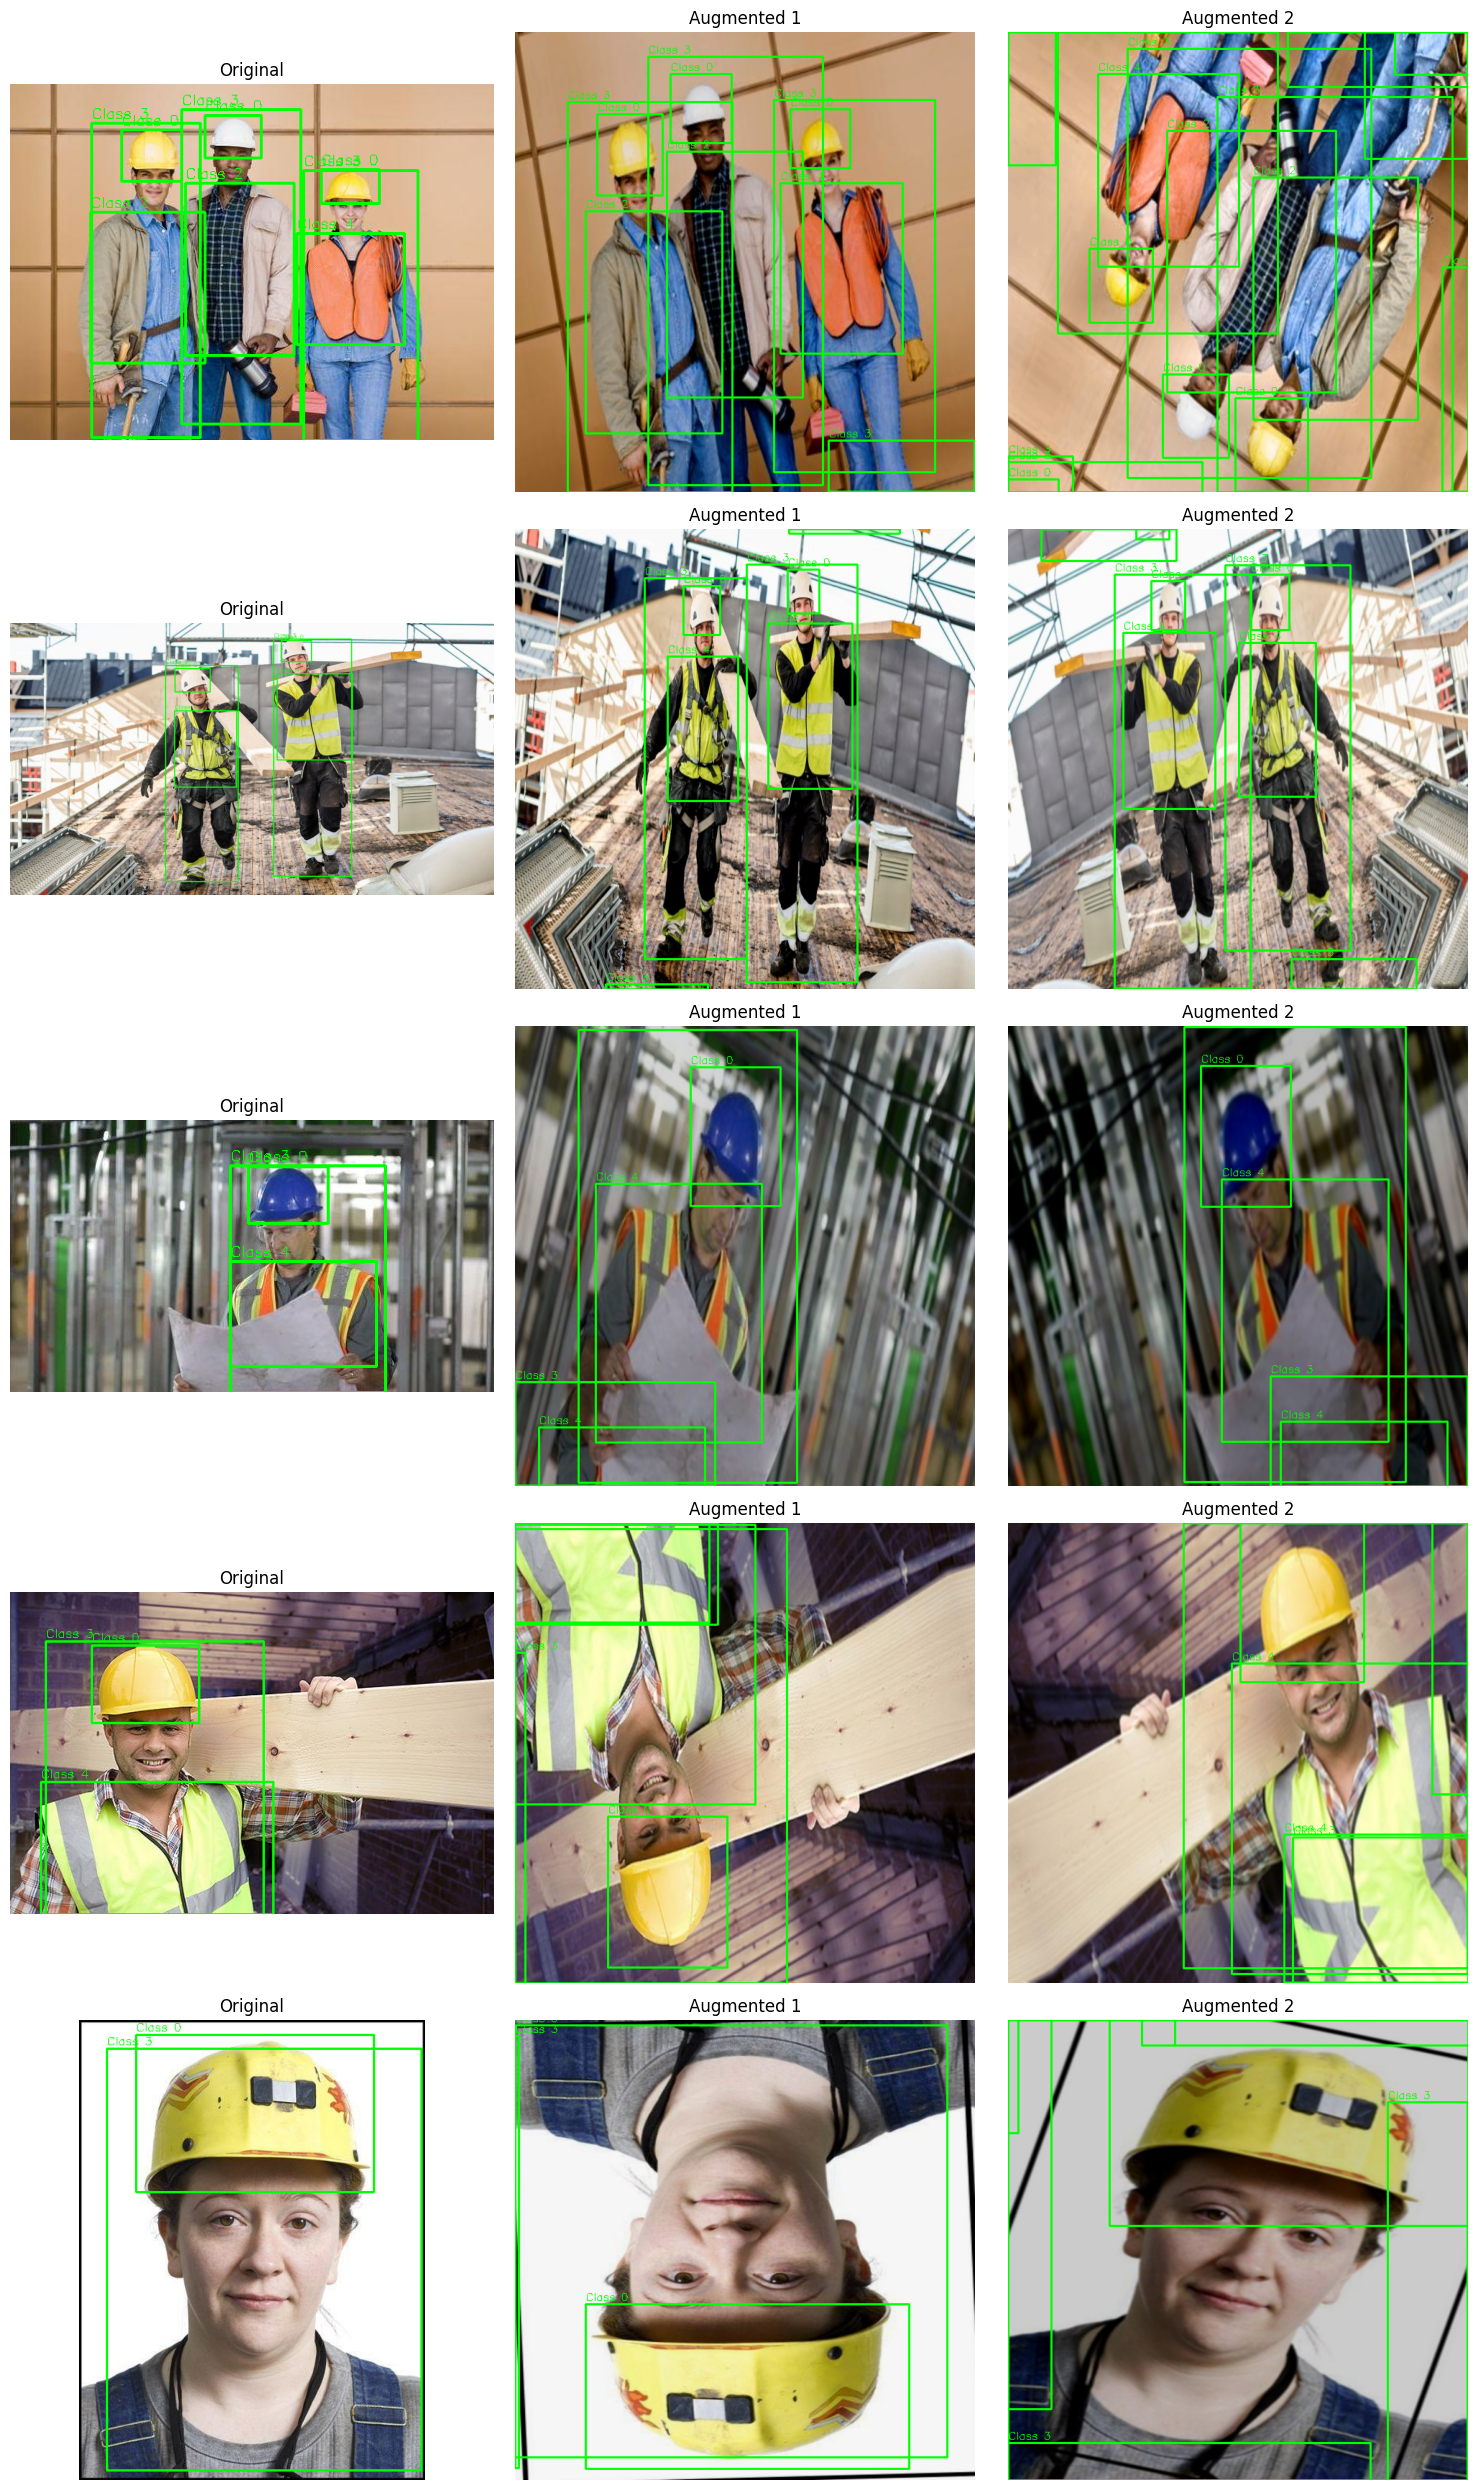

In [19]:
display_original_with_augmented_pairs(train_images_dir, train_labels_dir, aug_images_dir, aug_labels_dir, num_examples=5)

## Generate YAML configuration file

In [20]:
CLASS_NAMES = ['helmet', 'no-helmet', 'no-vest', 'person', 'vest']

In [21]:
import yaml
from pathlib import Path

def create_yaml_file(dataset_path, train_images, val_images, test_images=None, class_names=CLASS_NAMES):
    data = {
        'path': str(dataset_path),
        'train': str(Path(train_images).relative_to(dataset_path)),
        'val': str(Path(val_images).relative_to(dataset_path)),
    }

    if test_images:
        data['test'] = str(Path(test_images).relative_to(dataset_path))

    data['nc'] = len(class_names)
    data['names'] = class_names

    yaml_path = Path(dataset_path) / 'dataset.yaml'
    with open(yaml_path, 'w') as file:
        yaml.dump(data, file, default_flow_style=False)

    print(f"YAML file created at {yaml_path}")

In [22]:
dataset_root = Path("/home/rowan/safety-construction/dataset")
train_images_dir = dataset_root / "augmented/train/images"
val_images_dir = dataset_root / "valid/images"
test_images_dir = dataset_root / "test/images"

In [23]:
create_yaml_file(dataset_root, train_images_dir, val_images_dir, test_images_dir, class_names=CLASS_NAMES)

YAML file created at /home/rowan/safety-construction/dataset/dataset.yaml


# Train YOLOv11 model

In [24]:
from ultralytics import YOLO
import matplotlib.pyplot as plt
import pandas as pd

In [28]:
model = YOLO("yolo11n.pt")

results = model.train(
    data="/home/rowan/safety-construction/dataset/dataset.yaml",
    epochs=100,
    batch=16,
    lr0=1e-4,
    imgsz=640,
    project="/home/rowan/safety-construction"
)

metrics = model.val()

print(metrics)

New https://pypi.org/project/ultralytics/8.3.59 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.53 🚀 Python-3.10.12 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 3060, 12288MiB)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=/home/rowan/safety-construction/dataset/dataset.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=/home/rowan/safety-construction, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, c

train: Scanning /home/rowan/safety-construction/dataset/augmented/train/labels.cache... 1994 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1994/1994 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /home/rowan/safety-construction/dataset/valid/labels.cache... 119 images, 0 backgrounds, 0 corrupt: 100%|██████████| 119/119 [00:00<?, ?it/s]


Plotting labels to /home/rowan/safety-construction/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.0001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001111, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/rowan/safety-construction/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      2.96G      1.802      2.837      1.825        123        640: 100%|██████████| 125/125 [00:18<00:00,  6.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.58it/s]

                   all        119        715       0.64      0.499      0.457      0.187



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      3.17G       1.72      1.939      1.763        115        640: 100%|██████████| 125/125 [00:16<00:00,  7.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.28it/s]

                   all        119        715       0.74      0.505      0.535      0.236



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      2.99G      1.685      1.842      1.724        161        640: 100%|██████████| 125/125 [00:16<00:00,  7.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.24it/s]

                   all        119        715      0.733      0.491      0.516      0.186



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      2.88G       1.67      1.797      1.728        158        640: 100%|██████████| 125/125 [00:16<00:00,  7.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.23it/s]

                   all        119        715      0.734      0.538      0.569      0.274



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      2.79G      1.628      1.716      1.695        134        640: 100%|██████████| 125/125 [00:16<00:00,  7.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.37it/s]

                   all        119        715      0.772      0.561      0.598       0.25



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      2.94G      1.628      1.658      1.688        174        640: 100%|██████████| 125/125 [00:16<00:00,  7.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.44it/s]

                   all        119        715      0.799       0.57      0.624      0.279



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      2.78G      1.595       1.62      1.673        136        640: 100%|██████████| 125/125 [00:16<00:00,  7.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.84it/s]

                   all        119        715      0.814        0.6      0.671      0.293



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      2.72G      1.572      1.584      1.641        118        640: 100%|██████████| 125/125 [00:16<00:00,  7.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.44it/s]

                   all        119        715      0.859      0.581      0.682      0.333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      2.93G      1.547      1.543       1.64        213        640: 100%|██████████| 125/125 [00:16<00:00,  7.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.68it/s]

                   all        119        715      0.818      0.578      0.683      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      2.99G      1.556      1.514      1.643        185        640: 100%|██████████| 125/125 [00:16<00:00,  7.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.84it/s]

                   all        119        715      0.861      0.605      0.715      0.341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      2.92G       1.54      1.503      1.633        105        640: 100%|██████████| 125/125 [00:16<00:00,  7.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.26it/s]

                   all        119        715      0.868      0.608      0.714      0.339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      2.91G      1.528      1.464      1.617        165        640: 100%|██████████| 125/125 [00:17<00:00,  7.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.56it/s]

                   all        119        715      0.854      0.636      0.774      0.358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      3.06G      1.511      1.453        1.6        147        640: 100%|██████████| 125/125 [00:16<00:00,  7.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.02it/s]

                   all        119        715      0.787      0.678      0.743      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      2.93G      1.515      1.423      1.607         97        640: 100%|██████████| 125/125 [00:17<00:00,  7.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.88it/s]

                   all        119        715      0.675      0.708      0.745      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      2.96G      1.491        1.4      1.582        123        640: 100%|██████████| 125/125 [00:16<00:00,  7.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.10it/s]

                   all        119        715      0.646      0.779      0.779       0.37



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      2.84G      1.493      1.413      1.595        153        640: 100%|██████████| 125/125 [00:16<00:00,  7.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.18it/s]

                   all        119        715      0.675      0.784      0.798      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      3.14G      1.481      1.394      1.582        141        640: 100%|██████████| 125/125 [00:16<00:00,  7.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.13it/s]

                   all        119        715      0.776      0.703      0.783      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      2.93G      1.464      1.361      1.573        160        640: 100%|██████████| 125/125 [00:16<00:00,  7.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.10it/s]

                   all        119        715      0.642      0.628      0.724      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      2.79G      1.455      1.323      1.556        209        640: 100%|██████████| 125/125 [00:17<00:00,  7.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.73it/s]

                   all        119        715      0.743      0.728      0.739      0.362



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      2.79G      1.447      1.322      1.553        179        640: 100%|██████████| 125/125 [00:16<00:00,  7.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.11it/s]

                   all        119        715       0.65       0.76      0.779      0.362



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      3.05G      1.442      1.323      1.548        107        640: 100%|██████████| 125/125 [00:16<00:00,  7.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.24it/s]

                   all        119        715      0.715      0.791      0.816      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      2.92G      1.452      1.314      1.551        144        640: 100%|██████████| 125/125 [00:17<00:00,  7.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.96it/s]

                   all        119        715      0.822      0.667      0.766      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      2.89G      1.426      1.274      1.535        144        640: 100%|██████████| 125/125 [00:18<00:00,  6.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.45it/s]

                   all        119        715       0.84      0.708      0.795      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      2.88G      1.423      1.269      1.533        137        640: 100%|██████████| 125/125 [00:17<00:00,  7.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.90it/s]

                   all        119        715      0.752      0.731      0.808       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      2.74G      1.423      1.269      1.525        155        640: 100%|██████████| 125/125 [00:16<00:00,  7.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.43it/s]

                   all        119        715      0.814      0.774      0.841      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      2.67G      1.406       1.23      1.509        166        640: 100%|██████████| 125/125 [00:17<00:00,  7.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.91it/s]

                   all        119        715      0.879      0.666      0.773      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      3.06G       1.41      1.257      1.525        139        640: 100%|██████████| 125/125 [00:18<00:00,  6.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.00it/s]

                   all        119        715      0.728      0.793      0.839      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      2.83G      1.394      1.226      1.519        118        640: 100%|██████████| 125/125 [00:18<00:00,  6.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.59it/s]

                   all        119        715      0.802      0.812      0.854      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      2.81G      1.388      1.235      1.504        159        640: 100%|██████████| 125/125 [00:17<00:00,  7.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.69it/s]

                   all        119        715      0.762      0.764      0.801      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      2.93G      1.411      1.209      1.517        162        640: 100%|██████████| 125/125 [00:17<00:00,  7.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.96it/s]

                   all        119        715      0.875      0.662      0.779       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      2.85G       1.38      1.192      1.487        130        640: 100%|██████████| 125/125 [00:16<00:00,  7.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.38it/s]

                   all        119        715      0.733      0.747      0.793      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      3.03G      1.383        1.2      1.497        152        640: 100%|██████████| 125/125 [00:16<00:00,  7.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.64it/s]

                   all        119        715      0.786      0.764      0.824      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      3.04G      1.377      1.191      1.497        116        640: 100%|██████████| 125/125 [00:16<00:00,  7.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.82it/s]

                   all        119        715       0.76      0.722      0.773      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      2.77G      1.358      1.174      1.485        112        640: 100%|██████████| 125/125 [00:17<00:00,  7.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.85it/s]

                   all        119        715       0.74      0.828      0.848      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100       2.9G      1.359      1.185      1.487         63        640: 100%|██████████| 125/125 [00:17<00:00,  7.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.80it/s]

                   all        119        715      0.767      0.809      0.859      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      3.08G      1.364      1.161      1.478        119        640: 100%|██████████| 125/125 [00:17<00:00,  7.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.00it/s]

                   all        119        715      0.732       0.81      0.819      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      3.02G      1.342      1.153      1.481        120        640: 100%|██████████| 125/125 [00:16<00:00,  7.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.58it/s]

                   all        119        715      0.875       0.71      0.807      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      2.69G      1.333      1.132      1.464        204        640: 100%|██████████| 125/125 [00:17<00:00,  7.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.23it/s]

                   all        119        715      0.774      0.657      0.777      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      3.34G      1.325      1.125      1.454        161        640: 100%|██████████| 125/125 [00:16<00:00,  7.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.50it/s]

                   all        119        715      0.864      0.716      0.807      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      3.21G      1.337      1.131      1.463        126        640: 100%|██████████| 125/125 [00:16<00:00,  7.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.41it/s]

                   all        119        715      0.857      0.728      0.815      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      3.19G      1.323      1.107      1.459        159        640: 100%|██████████| 125/125 [00:16<00:00,  7.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.42it/s]

                   all        119        715      0.767      0.792      0.849      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      2.83G       1.33      1.117       1.46        161        640: 100%|██████████| 125/125 [00:16<00:00,  7.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.00it/s]

                   all        119        715      0.862      0.699      0.792       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      2.83G      1.318      1.113      1.446        163        640: 100%|██████████| 125/125 [00:16<00:00,  7.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.94it/s]

                   all        119        715      0.766      0.765      0.828      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      2.87G      1.317      1.103      1.447        149        640: 100%|██████████| 125/125 [00:16<00:00,  7.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.20it/s]

                   all        119        715      0.866      0.715      0.812       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      3.02G      1.309      1.107      1.448        132        640: 100%|██████████| 125/125 [00:16<00:00,  7.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.15it/s]

                   all        119        715      0.827      0.767      0.813      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      2.85G      1.301      1.081      1.437        172        640: 100%|██████████| 125/125 [00:16<00:00,  7.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.39it/s]

                   all        119        715       0.77      0.783      0.839      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      2.88G      1.292      1.088      1.436        189        640: 100%|██████████| 125/125 [00:17<00:00,  7.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.03it/s]

                   all        119        715      0.754      0.761      0.812      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      2.91G      1.302       1.07      1.441        155        640: 100%|██████████| 125/125 [00:17<00:00,  7.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.27it/s]

                   all        119        715      0.737      0.801      0.828      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      2.79G      1.292      1.083      1.435        139        640: 100%|██████████| 125/125 [00:17<00:00,  7.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.41it/s]

                   all        119        715      0.835      0.701       0.81      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      3.17G      1.268      1.051      1.419        120        640: 100%|██████████| 125/125 [00:16<00:00,  7.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.96it/s]

                   all        119        715      0.861      0.776      0.837      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      2.85G      1.275       1.03      1.417        116        640: 100%|██████████| 125/125 [00:16<00:00,  7.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.09it/s]

                   all        119        715      0.793      0.755      0.814      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      2.93G      1.282      1.048      1.416        185        640: 100%|██████████| 125/125 [00:16<00:00,  7.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.58it/s]

                   all        119        715        0.8       0.76       0.81      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      2.83G      1.279       1.06      1.422         71        640: 100%|██████████| 125/125 [00:16<00:00,  7.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.37it/s]

                   all        119        715      0.845       0.71      0.824      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      2.97G      1.264      1.032      1.412        172        640: 100%|██████████| 125/125 [00:16<00:00,  7.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.87it/s]

                   all        119        715      0.844      0.729      0.776      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      2.94G      1.263      1.025      1.409        122        640: 100%|██████████| 125/125 [00:16<00:00,  7.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.08it/s]

                   all        119        715      0.834      0.707      0.778      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      3.01G      1.255      1.019      1.402        160        640: 100%|██████████| 125/125 [00:16<00:00,  7.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.96it/s]

                   all        119        715      0.756      0.801      0.829      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      2.71G      1.261      1.012      1.409        119        640: 100%|██████████| 125/125 [00:16<00:00,  7.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.38it/s]

                   all        119        715      0.782      0.791      0.842      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      3.18G      1.256       1.01      1.397        176        640: 100%|██████████| 125/125 [00:17<00:00,  7.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.36it/s]

                   all        119        715      0.773       0.72       0.82      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      2.85G       1.25      1.007      1.395        147        640: 100%|██████████| 125/125 [00:18<00:00,  6.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.53it/s]

                   all        119        715      0.847      0.736      0.834      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      3.07G      1.244      1.008      1.406        101        640: 100%|██████████| 125/125 [00:18<00:00,  6.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.14it/s]

                   all        119        715      0.907      0.709      0.806       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      2.92G      1.236     0.9989      1.391        117        640: 100%|██████████| 125/125 [00:18<00:00,  6.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.12it/s]

                   all        119        715      0.912      0.767      0.815       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100       2.9G      1.231     0.9887      1.389        125        640: 100%|██████████| 125/125 [00:17<00:00,  7.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.42it/s]

                   all        119        715      0.881      0.747      0.804      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      3.05G      1.235      0.984      1.386        108        640: 100%|██████████| 125/125 [00:16<00:00,  7.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.33it/s]

                   all        119        715      0.898      0.746      0.809      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      2.98G      1.221     0.9782      1.378        102        640: 100%|██████████| 125/125 [00:17<00:00,  7.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.06it/s]

                   all        119        715      0.887      0.704      0.832      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      2.92G       1.22     0.9748      1.379        130        640: 100%|██████████| 125/125 [00:17<00:00,  7.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.72it/s]

                   all        119        715       0.87      0.719      0.795      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      2.87G      1.214     0.9569      1.375        165        640: 100%|██████████| 125/125 [00:17<00:00,  7.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.44it/s]

                   all        119        715      0.899      0.738      0.796      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      2.88G      1.211     0.9689      1.373        125        640: 100%|██████████| 125/125 [00:17<00:00,  7.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.37it/s]

                   all        119        715      0.778      0.776      0.805      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      3.15G      1.199     0.9583      1.367         95        640: 100%|██████████| 125/125 [00:17<00:00,  7.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.67it/s]

                   all        119        715      0.898      0.744      0.807      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      2.68G        1.2      0.946      1.363        129        640: 100%|██████████| 125/125 [00:17<00:00,  7.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.16it/s]

                   all        119        715      0.837      0.736      0.803      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      2.91G      1.198     0.9471      1.356        143        640: 100%|██████████| 125/125 [00:16<00:00,  7.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.19it/s]

                   all        119        715      0.857       0.72      0.807      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      2.83G       1.21     0.9511      1.368        146        640: 100%|██████████| 125/125 [00:17<00:00,  7.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.36it/s]

                   all        119        715      0.878      0.701      0.804       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      3.02G      1.186     0.9467      1.357        120        640: 100%|██████████| 125/125 [00:16<00:00,  7.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.21it/s]

                   all        119        715        0.9      0.738      0.797      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      2.83G       1.18     0.9267      1.353        132        640: 100%|██████████| 125/125 [00:16<00:00,  7.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.39it/s]

                   all        119        715      0.876      0.755      0.798      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      2.82G      1.185      0.938      1.358        120        640: 100%|██████████| 125/125 [00:16<00:00,  7.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.37it/s]

                   all        119        715      0.904      0.709      0.846      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      2.84G      1.174     0.9275      1.343        188        640: 100%|██████████| 125/125 [00:17<00:00,  7.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.12it/s]

                   all        119        715      0.811      0.772      0.845      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      3.25G      1.175     0.9173      1.339        153        640: 100%|██████████| 125/125 [00:16<00:00,  7.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.18it/s]


                   all        119        715      0.829      0.737        0.8      0.431

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      2.81G      1.169     0.9091      1.343        112        640: 100%|██████████| 125/125 [00:16<00:00,  7.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.76it/s]

                   all        119        715      0.928      0.714      0.814      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      2.99G      1.163     0.9053      1.334        150        640: 100%|██████████| 125/125 [00:16<00:00,  7.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.96it/s]

                   all        119        715      0.901      0.755      0.824      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      2.65G      1.166     0.9224      1.342        137        640: 100%|██████████| 125/125 [00:16<00:00,  7.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.08it/s]

                   all        119        715      0.892      0.738      0.803      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      2.92G      1.161     0.9174       1.34        138        640: 100%|██████████| 125/125 [00:16<00:00,  7.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.16it/s]

                   all        119        715      0.901      0.719      0.814      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      2.85G      1.147     0.8936      1.333        162        640: 100%|██████████| 125/125 [00:16<00:00,  7.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.04it/s]

                   all        119        715       0.89      0.708      0.821      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      2.85G      1.163     0.8913      1.334        100        640: 100%|██████████| 125/125 [00:16<00:00,  7.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.95it/s]

                   all        119        715      0.901      0.735      0.836      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      2.89G       1.14     0.8854      1.328        135        640: 100%|██████████| 125/125 [00:17<00:00,  7.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.41it/s]

                   all        119        715      0.908      0.725       0.83      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      2.97G      1.135     0.8862      1.327        199        640: 100%|██████████| 125/125 [00:16<00:00,  7.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.47it/s]

                   all        119        715      0.883      0.744      0.804      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      2.83G      1.139     0.8853      1.314         78        640: 100%|██████████| 125/125 [00:16<00:00,  7.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.47it/s]

                   all        119        715      0.873      0.747      0.815      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      3.08G      1.133     0.8766      1.319        111        640: 100%|██████████| 125/125 [00:16<00:00,  7.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.04it/s]

                   all        119        715      0.879      0.722      0.788      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      2.64G      1.126     0.8749      1.312        194        640: 100%|██████████| 125/125 [00:16<00:00,  7.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.01it/s]

                   all        119        715      0.807      0.776      0.824      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      2.67G      1.132     0.8716      1.314         97        640: 100%|██████████| 125/125 [00:16<00:00,  7.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.60it/s]

                   all        119        715      0.891      0.735      0.833      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100         3G       1.13     0.8713      1.313        185        640: 100%|██████████| 125/125 [00:17<00:00,  7.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.07it/s]

                   all        119        715      0.893      0.739      0.823      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      2.76G      1.116     0.8632      1.306         86        640: 100%|██████████| 125/125 [00:17<00:00,  7.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.04it/s]

                   all        119        715      0.907       0.73       0.79      0.429


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      2.55G      1.069     0.7284        1.3         84        640: 100%|██████████| 125/125 [00:16<00:00,  7.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.52it/s]

                   all        119        715      0.914      0.719      0.796      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      2.55G      1.064     0.7093      1.306         86        640: 100%|██████████| 125/125 [00:15<00:00,  7.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.62it/s]

                   all        119        715      0.849      0.733      0.788      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      2.54G      1.044     0.6926      1.291         93        640: 100%|██████████| 125/125 [00:16<00:00,  7.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.68it/s]

                   all        119        715      0.856      0.739       0.79      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      2.59G       1.04      0.689      1.287        106        640: 100%|██████████| 125/125 [00:16<00:00,  7.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.92it/s]

                   all        119        715      0.842      0.743      0.795      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      2.53G      1.029     0.6782       1.28        111        640: 100%|██████████| 125/125 [00:16<00:00,  7.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.72it/s]

                   all        119        715       0.83      0.742      0.793      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      2.57G      1.026     0.6719      1.277         80        640: 100%|██████████| 125/125 [00:15<00:00,  7.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.28it/s]

                   all        119        715      0.776      0.753      0.803      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      2.54G      1.019     0.6722      1.277         65        640: 100%|██████████| 125/125 [00:18<00:00,  6.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.35it/s]

                   all        119        715        0.9      0.737      0.797      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      2.51G      1.007     0.6661      1.262         69        640: 100%|██████████| 125/125 [00:16<00:00,  7.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.37it/s]

                   all        119        715      0.917      0.726      0.804      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      2.57G      1.012      0.658      1.265         68        640: 100%|██████████| 125/125 [00:15<00:00,  7.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.47it/s]

                   all        119        715      0.843      0.748      0.801      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      2.64G      1.003     0.6567      1.268         56        640: 100%|██████████| 125/125 [00:16<00:00,  7.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.69it/s]

                   all        119        715      0.921       0.73      0.789      0.432



100 epochs completed in 0.495 hours.
Optimizer stripped from /home/rowan/safety-construction/train/weights/last.pt, 5.5MB
Optimizer stripped from /home/rowan/safety-construction/train/weights/best.pt, 5.5MB

Validating /home/rowan/safety-construction/train/weights/best.pt...
Ultralytics 8.3.53 🚀 Python-3.10.12 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 3060, 12288MiB)
YOLO11n summary (fused): 238 layers, 2,583,127 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.12it/s]


                   all        119        715      0.812      0.772      0.845      0.455
                helmet        117        232      0.859      0.914      0.924      0.495
             no-helmet          6         11      0.777      0.322      0.659       0.29
               no-vest         52         90      0.773      0.835      0.802      0.375
                person        115        241      0.815      0.934      0.924      0.615
                  vest         74        141      0.837      0.858      0.915      0.499
Speed: 0.3ms preprocess, 3.5ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to /home/rowan/safety-construction/train
Ultralytics 8.3.53 🚀 Python-3.10.12 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 3060, 12288MiB)
YOLO11n summary (fused): 238 layers, 2,583,127 parameters, 0 gradients, 6.3 GFLOPs


val: Scanning /home/rowan/safety-construction/dataset/valid/labels.cache... 119 images, 0 backgrounds, 0 corrupt: 100%|██████████| 119/119 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:06<00:00,  1.31it/s]


                   all        119        715      0.899      0.733      0.852      0.458
                helmet        117        232      0.905      0.875      0.921       0.49
             no-helmet          6         11          1      0.272      0.698      0.312
               no-vest         52         90      0.812       0.77      0.804      0.367
                person        115        241      0.889      0.917      0.923      0.617
                  vest         74        141      0.886      0.829      0.914      0.504
Speed: 0.4ms preprocess, 6.1ms inference, 0.0ms loss, 8.8ms postprocess per image
Results saved to /home/rowan/safety-construction/train2
ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7f9714110af0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confiden

                             Metric     Value
0  Mean Average Precision (mAP@0.5)  0.852081
1                         Precision  0.898548
2                            Recall  0.732591


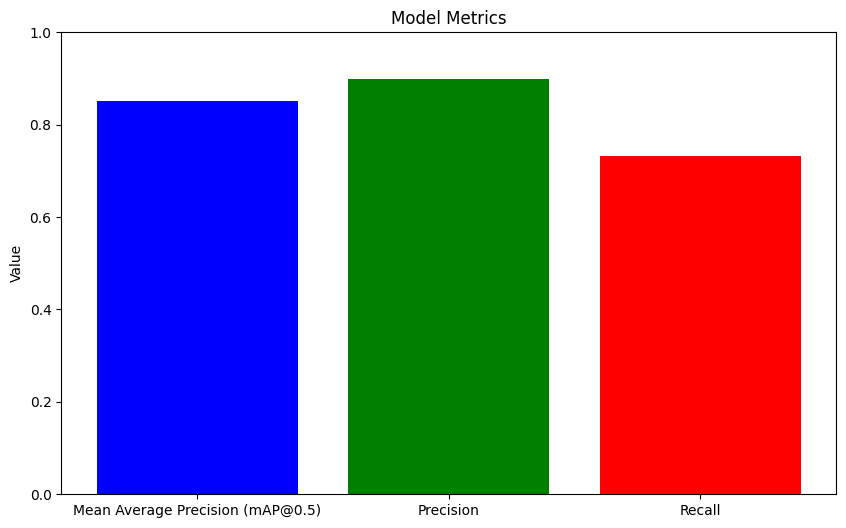

In [29]:
mAP50 = metrics.results_dict.get('metrics/mAP50(B)', 0)
precision = metrics.results_dict.get('metrics/precision(B)', 0)
recall = metrics.results_dict.get('metrics/recall(B)', 0)

metrics_df = pd.DataFrame({
    "Metric": ["Mean Average Precision (mAP@0.5)",
               "Precision", "Recall"],
    "Value": [mAP50, precision, recall]
})

print(metrics_df)

plt.figure(figsize=(10, 6))
plt.bar(metrics_df["Metric"], metrics_df["Value"], color=['blue', 'green', 'red'])
plt.title("Model Metrics")
plt.ylabel("Value")
plt.ylim(0, 1)
plt.show()

# Exporting model to Hugging Face

In [30]:
model = YOLO("/home/rowan/safety-construction/train/weights/best.pt")

model.export(format="onnx")

Ultralytics 8.3.53 🚀 Python-3.10.12 torch-2.5.1+cu124 CPU (13th Gen Intel Core(TM) i5-13600K)
YOLO11n summary (fused): 238 layers, 2,583,127 parameters, 0 gradients, 6.3 GFLOPs

PyTorch: starting from '/home/rowan/safety-construction/train/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 9, 8400) (5.2 MB)
requirements: Ultralytics requirements ['onnxslim', 'onnxruntime-gpu'] not found, attempting AutoUpdate...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.8/142.8 KB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 291.5/291.5 MB 53.7 MB/s eta 0:00:00

requirements: AutoUpdate success ✅ 12.1s, installed 2 packages: ['onnxslim', 'onnxruntime-gpu']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect


ONNX: starting export with onnx 1.17.0 opset 19...
ONNX: slimming with onnxslim 0.1.47...
ONNX: export success ✅ 13.0s, saved as '/home/rowan/safety-construction/train/weights/best.onnx' (10.1 MB)

Export complete (14

'/home/rowan/safety-construction/train/weights/best.onnx'

## Deploy model on Hugging Face

In [31]:
from huggingface_hub import HfApi, HfFolder, Repository
import locale

In [32]:
# Define a function to override the default locale setting with UTF-8. This comes from search result [2]
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"

In [ ]:
# Override locale settings
locale.getpreferredencoding = getpreferredencoding

In [33]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    A token is already saved on your machine. Run `huggingface-cli whoami` to get more information or `huggingface-cli logout` if you want to log out.
    Setting a new token will erase the existing one.
    To log in, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): Traceback (most recent call last):
  File "/home/rowan/safety-construct

In [34]:
from huggingface_hub import create_repo, upload_file

repo_id = "ltl1313ltl/construction-safety"

upload_file(
    path_or_fileobj="/home/rowan/safety-construction/train/weights/best.pt",
    path_in_repo="model.pt",
    repo_id=repo_id,
    repo_type="model"
)

print(f"Model uploaded!")

best.pt: 100%|██████████| 5.48M/5.48M [00:02<00:00, 2.67MB/s]


Model uploaded!


In [ ]:
trained_model = YOLO('/content/runs/detect/train/weights/best.pt')

test_image_path = '/content/pic3.png'

results = trained_model.predict(test_image_path, save=True, save_txt=True)

for result in results:
    img = result.plot()
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

FileNotFoundError: /content/pic3.png does not exist